# Join the three surveys' data into a single longitudinal data file

Also generates the image below, visualizing participant continuity across surveys.

![venn_participation_counts](plots/venn_participation_counts.png)


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Configuation" data-toc-modified-id="Configuation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Configuation</a></span></li><li><span><a href="#Import,-load-data" data-toc-modified-id="Import,-load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import, load data</a></span></li><li><span><a href="#Merge-into-one-giant-dataframe,-check-for-conflicting-data" data-toc-modified-id="Merge-into-one-giant-dataframe,-check-for-conflicting-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Merge into one giant dataframe, check for conflicting data</a></span><ul class="toc-item"><li><span><a href="#Avoid-conflicts-by-giving-each-column-in-each-dataset-a-survey-specific-suffix" data-toc-modified-id="Avoid-conflicts-by-giving-each-column-in-each-dataset-a-survey-specific-suffix-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Avoid conflicts by giving each column in each dataset a survey-specific suffix</a></span></li><li><span><a href="#The-spring-well-being-survey-has-dorm-names,-not-NIDS---translate-between-them" data-toc-modified-id="The-spring-well-being-survey-has-dorm-names,-not-NIDS---translate-between-them-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>The spring well-being survey has dorm names, not NIDS - translate between them</a></span></li><li><span><a href="#Merge-across-the-three-dataframes-using-outer-join,-so-no-data-is-lost" data-toc-modified-id="Merge-across-the-three-dataframes-using-outer-join,-so-no-data-is-lost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Merge across the three dataframes using outer join, so no data is lost</a></span></li><li><span><a href="#Check-that-no-participant-is-listed-in-different-dorms-on-different-surveys" data-toc-modified-id="Check-that-no-participant-is-listed-in-different-dorms-on-different-surveys-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Check that no participant is listed in different dorms on different surveys</a></span></li><li><span><a href="#Create-one-dorm-(NID)-column-instead-of-three-(identical,-survey-specific)-columns" data-toc-modified-id="Create-one-dorm-(NID)-column-instead-of-three-(identical,-survey-specific)-columns-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Create one dorm (NID) column instead of three (identical, survey-specific) columns</a></span></li><li><span><a href="#Remove-any-&quot;extra&quot;-columns-added-in-postprocessing-(these-will-be-lowercase-columns)" data-toc-modified-id="Remove-any-&quot;extra&quot;-columns-added-in-postprocessing-(these-will-be-lowercase-columns)-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Remove any "extra" columns added in postprocessing (these will be lowercase columns)</a></span></li><li><span><a href="#Save-results" data-toc-modified-id="Save-results-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Save results</a></span></li></ul></li><li><span><a href="#Visualize-participant-continuity-across-datasets" data-toc-modified-id="Visualize-participant-continuity-across-datasets-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visualize participant continuity across datasets</a></span></li></ul></div>

## Configuation

In [1]:
DATA_DIR = '/Users/everettwetchler/src/research/zaki/github/analysis/data/'
OUTPUT_VENN_DIAGRAM_FILENAME = '/Users/everettwetchler/src/research/zaki/github/analysis/plots/venn_participation_counts.png'

<div style="background-color: #A33;height: 20px"></div> <!-- Red bar -->

## Import, load data

In [2]:
####################################################
# Boilerplate import/setup code for general analysis
# everett.wetchler@gmail.com
####################################################

# Plot directly in notebook
# NOTE: break this command into it's own cell, and run
# it BEFORE everything below it. Unfortunately that's
# the only way to get the plot settings to stick.
%matplotlib inline

Everett Wetchler 2019-12-03 11:44:42 PST 

CPython 3.6.5
IPython 7.8.0

numpy 1.17.3
pandas 0.25.1
matplotlib 3.1.0
seaborn 0.9.0
watermark 2.0.1


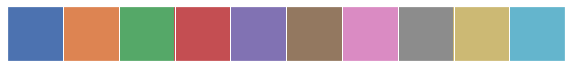

In [3]:
import datetime as dt
import os
import random
import simplejson as json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
sns.set()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

# Customize default chart graphics
mpl.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

# It's useful to have some named colors handy
(SNS_BLUE, SNS_ORANGE, SNS_GREEN,
 SNS_RED, SNS_PURPLE, SNS_BROWN,
 SNS_PINK, SNS_GRAY, SNS_YELLOW,
 SNS_CYAN) = sns.color_palette()
sns.palplot(sns.color_palette())

# Watermark extension to print version/system information
# Flags:
# -a [author] --v (python/ipython versions) -d (date)
# -t (time) -z (timezone) -r (repo)
# -g (git hash) -w (watermark version)
# -p [packages] (package info)
%load_ext watermark
%watermark -a 'Everett Wetchler' -v -d -t -z -w -p numpy,pandas,matplotlib,seaborn

####################################################
# END Boilerplate
####################################################

In [4]:
from matplotlib_venn import venn3

In [5]:
import scipy
import scipy.cluster.hierarchy as sch

def upper_triangle(X):
    Y = X.copy()
    for i in range(len(X)):
        for j in range(i, len(X)):
            Y.iloc[j, i] = None
    return Y

def clustered_corr(df, triangle=True):
    '''Method/code from https://github.com/TheLoneNut/
           CorrelationMatrixClustering/blob/master/CorrelationMatrixClustering.ipynb'''
    X = df.corr()
    for i in range(len(X)):
        X.iloc[i, i] = 0
    X = X.values
    d = sch.distance.pdist(X)   # vector of (N choose 2) pairwise distances
    L = sch.linkage(d, method='complete')
    ind = sch.fcluster(L, 0.5*d.max(), 'distance')
    columns = [df.columns.tolist()[i] for i in list((np.argsort(ind)))]
    corr = df[columns].corr()
    if triangle:
        return upper_triangle(corr)
    return corr

In [6]:
prefrosh = pd.read_csv(os.path.join(DATA_DIR, 'postprocessed/prefrosh.csv'))
print(prefrosh.shape)
prefrosh.head()

(636, 28)


,PID,NID,DID,Extraversion,BAS,NTB,EC,PD,PT,Prosociality,Loneliness,Loneliness_R,PSS,PSS_R,Subj_Happiness,SWL,MalleableEmpathy,EMPATHY,POSITIVITY,NEGATIVITY,LIFE_SATISFACTION,questions_complete,questions_incomplete,scores_complete,scores_incomplete,time_seconds,time_minutes,date
0,UPl0A7hyV0,NaN,NaN,1.000,1.769231,2.1,3.00,1.50,3.00,3.166667,1.750,2.250,1.00,3.00,4.00,3.8,4.000000,3.291667,1.384615,1.800,3.26250,83,0,18,0,377,6,2018-09-10 16:12:15
1,ra1xsp248Q,NaN,NaN,1.875,2.461538,3.0,3.75,1.25,2.75,3.833333,1.875,2.125,2.50,1.50,2.75,4.4,3.333333,3.416667,2.168269,2.125,2.69375,83,0,18,0,385,6,2018-09-10 16:12:19
2,IqidLJtjxg,11.0,11.0,2.875,2.461538,1.8,3.25,2.00,3.00,3.250000,1.000,3.000,0.25,3.75,5.00,5.2,2.000000,2.875000,2.668269,1.900,4.23750,83,0,18,0,425,7,2018-09-10 16:13:12
3,GR9ggA8Ajc,9.0,9.0,3.375,2.461538,2.4,2.25,1.00,1.75,2.750000,0.750,3.250,1.50,2.50,4.75,6.0,4.333333,2.770833,2.918269,1.700,4.12500,83,0,18,0,449,7,2018-09-10 16:13:52
4,vgxlTMkQs5,7.0,7.0,1.250,1.769231,3.4,3.00,1.25,3.00,2.833333,2.750,1.250,2.50,1.50,1.25,3.0,2.000000,2.708333,1.509615,2.325,1.75000,83,0,18,0,454,7,2018-09-10 16:14:14


In [7]:
trait = pd.read_csv(os.path.join(DATA_DIR, 'postprocessed/trait.csv'))
print(trait.shape)
trait.head()

(305, 61)


,PID,NID,DID,Extraversion,Agreeableness,Openness,Conscientiousness,NPI,Positive_empathy,Pos_efficacy,Neg_efficacy,Pos_tendency,Neg_Tendency,CESD,STAI_Anxiety,Need_Belong,Prosociality,Loneliness,PSS,SubjHappiness,SWLS,Emp_theory,RS_1,RS_2,Self_Esteem,Self_monitor,Distress_Disclosure,Guidance,Warmth,Integration,Attachment,Nurturance,Reliable,Anticipated_Risks,Anticipated_Benefits,beq.nex,beq.pex,beq.str,PI,SI,CI,BFNE,BAS_drive,BAS_Fun_seeking,BAS_Fun_Reward_responsiveness,Suppression,Cogntive_Reappraisal,Extensic_improve,Extensic_worse,Intrinsic_imrpove,Intrinsic_worse,Empathic_Concern,Perspective_Taking,Personal_Distress,questions_complete,questions_incomplete,scores_complete,scores_incomplete,time_seconds,time_minutes,date
0,01DGcnKSFh,10,10,5.5,7.0,6.0,5.0,4.400000,5.714286,7.00,7.50,7.50,7.25,3.2,3.631579,4.3,3.666667,0.875,1.25,7.50,6.6,2.666667,5.125,4.625,1.5,17,3.500000,4.00,4.00,3.75,3.25,3.0,3.75,4.25,5.50,5.000000,7.75,5.666667,6.000000,4.50,4.750,3.000000,4.75,4.25,5.0,2.75,7.000000,6.000000,2.0,5.333333,2.75,3.666667,2.714286,1.000000,395,9,51,0,412913,6881,2018-10-06 11:43:51
1,060uyicrNj,9,9,3.5,4.5,3.5,6.0,4.333333,4.714286,6.50,6.25,5.75,6.75,3.6,2.842105,4.3,2.666667,1.875,1.75,5.25,6.2,3.833333,5.375,5.750,2.2,10,3.357143,2.50,3.25,3.25,2.50,3.0,3.25,4.25,4.00,3.166667,5.75,5.666667,4.500000,5.00,4.625,4.571429,4.50,4.00,3.6,5.00,6.333333,4.833333,5.0,4.500000,4.75,2.000000,2.428571,2.142857,395,9,51,0,6291,104,2018-10-05 18:44:03
2,08JYVDNSVE,2,2,7.0,8.0,6.0,6.5,3.666667,6.000000,7.25,7.75,6.00,4.50,3.2,3.578947,5.0,2.666667,2.000,2.75,4.75,5.4,4.000000,5.375,5.250,2.9,10,3.785714,2.75,3.50,3.50,3.00,3.0,3.25,6.00,4.50,7.166667,8.00,7.000000,5.500000,4.75,4.375,6.000000,3.50,4.50,5.0,4.50,6.833333,4.166667,2.0,3.500000,6.00,3.500000,3.285714,2.428571,395,9,51,0,9974,166,2018-10-05 16:39:09
3,09sqjhTBY5,4,4,2.5,4.5,6.0,5.5,3.066667,4.142857,5.00,6.75,4.25,3.00,2.4,2.473684,3.8,3.333333,1.125,0.75,4.75,4.8,3.500000,6.750,4.750,2.3,13,2.357143,3.25,3.25,3.25,3.25,2.0,3.25,5.00,4.25,3.500000,6.00,6.333333,5.000000,4.25,3.750,4.142857,3.50,4.00,4.2,4.25,4.666667,3.166667,2.0,3.166667,2.50,2.833333,2.142857,2.571429,396,8,51,0,2777,46,2018-10-07 17:30:58
4,0fgViPMzN8,7,7,6.0,6.5,7.0,5.5,3.600000,4.428571,6.75,6.00,4.50,3.25,2.8,2.526316,4.2,3.333333,0.500,1.25,6.25,6.0,0.500000,5.375,5.375,1.2,19,3.142857,4.00,4.00,3.50,3.75,3.0,4.00,5.00,4.00,4.333333,5.50,6.666667,5.833333,4.00,4.125,4.285714,3.50,2.25,4.0,6.25,6.166667,5.166667,2.0,3.166667,3.50,3.166667,2.428571,1.428571,395,9,51,0,2337,38,2018-10-07 17:35:17


In [8]:
wb = pd.read_csv(os.path.join(DATA_DIR, 'postprocessed/wellbeing_spring.csv'))
print(wb.shape)
wb.head()

(546, 19)


,PID,dorm,Wellbeing_self_17,Lonely,Stressed,Satisfied,Rumination,Wellbeing_self_18,Social_Anxiety,Wellbeing_self_22,Anxiety_1,Anxiety_2,Wellbeing_self_19,Depression,Anhedonia,Wellbeing_self_21,Belonging,Wellbeing,scores_missing
0,6jHJKaD4Cb,Alondra,4.0,4.0,0.0,4.0,0.0,4.0,4.0,4.0,2.0,0.0,4.0,4.0,0.0,4.0,4.0,2.714286,0
1,vcM4I7ahKq,Alondra,2.0,1.0,2.0,2.0,3.0,1.0,0.0,1.0,0.0,1.0,1.0,2.0,2.0,1.0,1.0,1.357143,0
2,GRS7z5mppv,Alondra,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,4.0,4.0,4.0,4.0,3.785714,0
3,eaZChV6Zzv,Alondra,4.0,4.0,0.0,3.0,2.0,4.0,4.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,2.928571,0
4,95dslV1gqt,Alondra,4.0,1.0,1.0,1.0,3.0,2.0,4.0,2.0,2.0,3.0,1.0,2.0,4.0,1.0,1.0,2.214286,0


<div style="background-color: #A33;height: 20px"></div> <!-- Red bar -->

## Merge into one giant dataframe, check for conflicting data

### Avoid conflicts by giving each column in each dataset a survey-specific suffix

In [9]:
prefrosh.columns = [c + "_prefrosh" for c in prefrosh.columns]
trait.columns = [c + "_trait" for c in trait.columns]
wb.columns = [c + "_wb" for c in wb.columns]

### The spring well-being survey has dorm names, not NIDS - translate between them

In [10]:
nid_to_dorm = {
  1: 'Alondra',
  2: 'Cedro',
  3: 'EAST',
  4: 'FroSoCo',
  5: 'JRo',
  6: 'Kimball',
  7: 'Larkin',
  8: 'Okada',
  9: 'Twain',
  10: 'Ujamaa',
  11: 'Meier or Naranja',
  13: 'Norcliffe or Adelfa',
  15: 'West FloMo',
}
for k, v in nid_to_dorm.items():
    nid_to_dorm[k] = v.strip().lower()
dorm_to_nid = dict((v, k) for k, v in nid_to_dorm.items())
dorm_to_nid

{'alondra': 1,
 'cedro': 2,
 'east': 3,
 'frosoco': 4,
 'jro': 5,
 'kimball': 6,
 'larkin': 7,
 'okada': 8,
 'twain': 9,
 'ujamaa': 10,
 'meier or naranja': 11,
 'norcliffe or adelfa': 13,
 'west flomo': 15}

In [11]:
wb['dorm_wb'] = wb['dorm_wb'].apply(lambda d: None if pd.isnull(d) else d.strip().lower())
wb['NID_wb'] = wb['dorm_wb'].apply(lambda dorm: dorm_to_nid.get(dorm, '"%s"' % dorm))
wb.drop('dorm_wb', axis=1, inplace=True)
print(wb['NID_wb'].value_counts().sort_index())
assert str(wb['NID_wb'].dtype) == 'int64', 'ERROR: some dorm lookups failed'
print("Dorm names successfully translated to NID values.")

1     33
2     54
4     77
5     52
7     48
8     41
9     38
10    47
11    53
13    50
15    53
Name: NID_wb, dtype: int64
Dorm names successfully translated to NID values.


### Merge across the three dataframes using outer join, so no data is lost

In [12]:
merged = pd.merge(prefrosh, trait, left_on='PID_prefrosh', right_on='PID_trait', how='outer')
merged['PID'] = merged['PID_prefrosh'].fillna(merged['PID_trait'])
merged = pd.merge(merged, wb, left_on='PID', right_on='PID_wb', how='outer')
merged['PID'] = merged['PID'].fillna(merged['PID_wb'])
merged.drop(['PID_prefrosh', 'PID_trait', 'PID_wb'], axis=1, inplace=True)
merged.head()

,NID_prefrosh,DID_prefrosh,Extraversion_prefrosh,BAS_prefrosh,NTB_prefrosh,EC_prefrosh,PD_prefrosh,PT_prefrosh,Prosociality_prefrosh,Loneliness_prefrosh,Loneliness_R_prefrosh,PSS_prefrosh,PSS_R_prefrosh,Subj_Happiness_prefrosh,SWL_prefrosh,MalleableEmpathy_prefrosh,EMPATHY_prefrosh,POSITIVITY_prefrosh,NEGATIVITY_prefrosh,LIFE_SATISFACTION_prefrosh,questions_complete_prefrosh,questions_incomplete_prefrosh,scores_complete_prefrosh,scores_incomplete_prefrosh,time_seconds_prefrosh,time_minutes_prefrosh,date_prefrosh,NID_trait,DID_trait,Extraversion_trait,Agreeableness_trait,Openness_trait,Conscientiousness_trait,NPI_trait,Positive_empathy_trait,Pos_efficacy_trait,Neg_efficacy_trait,Pos_tendency_trait,Neg_Tendency_trait,CESD_trait,STAI_Anxiety_trait,Need_Belong_trait,Prosociality_trait,Loneliness_trait,PSS_trait,SubjHappiness_trait,SWLS_trait,Emp_theory_trait,RS_1_trait,RS_2_trait,Self_Esteem_trait,Self_monitor_trait,Distress_Disclosure_trait,Guidance_trait,Warmth_trait,Integration_trait,Attachment_trait,Nurturance_trait,Reliable_trait,Anticipated_Risks_trait,Anticipated_Benefits_trait,beq.nex_trait,beq.pex_trait,beq.str_trait,PI_trait,SI_trait,CI_trait,BFNE_trait,BAS_drive_trait,BAS_Fun_seeking_trait,BAS_Fun_Reward_responsiveness_trait,Suppression_trait,Cogntive_Reappraisal_trait,Extensic_improve_trait,Extensic_worse_trait,Intrinsic_imrpove_trait,Intrinsic_worse_trait,Empathic_Concern_trait,Perspective_Taking_trait,Personal_Distress_trait,questions_complete_trait,questions_incomplete_trait,scores_complete_trait,scores_incomplete_trait,time_seconds_trait,time_minutes_trait,date_trait,PID,Wellbeing_self_17_wb,Lonely_wb,Stressed_wb,Satisfied_wb,Rumination_wb,Wellbeing_self_18_wb,Social_Anxiety_wb,Wellbeing_self_22_wb,Anxiety_1_wb,Anxiety_2_wb,Wellbeing_self_19_wb,Depression_wb,Anhedonia_wb,Wellbeing_self_21_wb,Belonging_wb,Wellbeing_wb,scores_missing_wb,NID_wb
0,NaN,NaN,1.000,1.769231,2.1,3.00,1.50,3.00,3.166667,1.750,2.250,1.00,3.00,4.00,3.8,4.000000,3.291667,1.384615,1.800,3.26250,83.0,0.0,18.0,0.0,377.0,6.0,2018-09-10 16:12:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UPl0A7hyV0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,1.875,2.461538,3.0,3.75,1.25,2.75,3.833333,1.875,2.125,2.50,1.50,2.75,4.4,3.333333,3.416667,2.168269,2.125,2.69375,83.0,0.0,18.0,0.0,385.0,6.0,2018-09-10 16:12:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ra1xsp248Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11.0,11.0,2.875,2.461538,1.8,3.25,2.00,3.00,3.250000,1.000,3.000,0.25,3.75,5.00,5.2,2.000000,2.875000,2.668269,1.900,4.23750,83.0,0.0,18.0,0.0,425.0,7.0,2018-09-10 16:13:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IqidLJtjxg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9.0,9.0,3.375,2.461538,2.4,2.25,1.00,1.75,2.750000,0.750,3.250,1.50,2.50,4.75,6.0,4.333333,2.770833,2.918269,1.700,4.12500,83.0,0.0,18.0,0.0,449.0,7.0,2018-09-10 16:13:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GR9ggA8Ajc,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,3.714286,0.0,9.0
4,7.0,7.0,1.250,1.769231,3.4,3.00,1.25,3.00,2.833333,2.750,1.250,2.50,1.50,1.25,3.0,2.000000,2.708333,1.509615,2.325,1.7500

### Check that no participant is listed in different dorms on different surveys

In [13]:
nid_cols = ['NID_prefrosh', 'NID_trait', 'NID_wb']
for c1 in nid_cols:
    for c2 in nid_cols:
        if c1 == c2: continue
        merged[c1] = merged[c1].fillna(merged[c2])

def is_mismatch(a, b):
    return (a != b) & a.notnull() & b.notnull()

mismatch = is_mismatch(merged['NID_trait'], merged['NID_prefrosh'])
mismatch = mismatch | is_mismatch(merged['NID_trait'], merged['NID_prefrosh'])
assert mismatch.sum() == 0, f"{mismatch.sum()} rows have mismatched NIDs from different datasets"
print("All good. No participant has different NIDs in different surveys")

All good. No participant has different NIDs in different surveys


### Create one dorm (NID) column instead of three (identical, survey-specific) columns

In [14]:
merged['NID'] = merged['NID_prefrosh']  # Any of these will do, all are the same
merged.drop([
    'NID_prefrosh', 'NID_trait', 'NID_wb',
    'DID_prefrosh', 'DID_trait'],
    axis=1, inplace=True)
merged = merged[['PID', 'NID'] + [c for c in merged.columns if c not in ('NID', 'PID')]]
merged.head()

,PID,NID,Extraversion_prefrosh,BAS_prefrosh,NTB_prefrosh,EC_prefrosh,PD_prefrosh,PT_prefrosh,Prosociality_prefrosh,Loneliness_prefrosh,Loneliness_R_prefrosh,PSS_prefrosh,PSS_R_prefrosh,Subj_Happiness_prefrosh,SWL_prefrosh,MalleableEmpathy_prefrosh,EMPATHY_prefrosh,POSITIVITY_prefrosh,NEGATIVITY_prefrosh,LIFE_SATISFACTION_prefrosh,questions_complete_prefrosh,questions_incomplete_prefrosh,scores_complete_prefrosh,scores_incomplete_prefrosh,time_seconds_prefrosh,time_minutes_prefrosh,date_prefrosh,Extraversion_trait,Agreeableness_trait,Openness_trait,Conscientiousness_trait,NPI_trait,Positive_empathy_trait,Pos_efficacy_trait,Neg_efficacy_trait,Pos_tendency_trait,Neg_Tendency_trait,CESD_trait,STAI_Anxiety_trait,Need_Belong_trait,Prosociality_trait,Loneliness_trait,PSS_trait,SubjHappiness_trait,SWLS_trait,Emp_theory_trait,RS_1_trait,RS_2_trait,Self_Esteem_trait,Self_monitor_trait,Distress_Disclosure_trait,Guidance_trait,Warmth_trait,Integration_trait,Attachment_trait,Nurturance_trait,Reliable_trait,Anticipated_Risks_trait,Anticipated_Benefits_trait,beq.nex_trait,beq.pex_trait,beq.str_trait,PI_trait,SI_trait,CI_trait,BFNE_trait,BAS_drive_trait,BAS_Fun_seeking_trait,BAS_Fun_Reward_responsiveness_trait,Suppression_trait,Cogntive_Reappraisal_trait,Extensic_improve_trait,Extensic_worse_trait,Intrinsic_imrpove_trait,Intrinsic_worse_trait,Empathic_Concern_trait,Perspective_Taking_trait,Personal_Distress_trait,questions_complete_trait,questions_incomplete_trait,scores_complete_trait,scores_incomplete_trait,time_seconds_trait,time_minutes_trait,date_trait,Wellbeing_self_17_wb,Lonely_wb,Stressed_wb,Satisfied_wb,Rumination_wb,Wellbeing_self_18_wb,Social_Anxiety_wb,Wellbeing_self_22_wb,Anxiety_1_wb,Anxiety_2_wb,Wellbeing_self_19_wb,Depression_wb,Anhedonia_wb,Wellbeing_self_21_wb,Belonging_wb,Wellbeing_wb,scores_missing_wb
0,UPl0A7hyV0,NaN,1.000,1.769231,2.1,3.00,1.50,3.00,3.166667,1.750,2.250,1.00,3.00,4.00,3.8,4.000000,3.291667,1.384615,1.800,3.26250,83.0,0.0,18.0,0.0,377.0,6.0,2018-09-10 16:12:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ra1xsp248Q,NaN,1.875,2.461538,3.0,3.75,1.25,2.75,3.833333,1.875,2.125,2.50,1.50,2.75,4.4,3.333333,3.416667,2.168269,2.125,2.69375,83.0,0.0,18.0,0.0,385.0,6.0,2018-09-10 16:12:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IqidLJtjxg,11.0,2.875,2.461538,1.8,3.25,2.00,3.00,3.250000,1.000,3.000,0.25,3.75,5.00,5.2,2.000000,2.875000,2.668269,1.900,4.23750,83.0,0.0,18.0,0.0,425.0,7.0,2018-09-10 16:13:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GR9ggA8Ajc,9.0,3.375,2.461538,2.4,2.25,1.00,1.75,2.750000,0.750,3.250,1.50,2.50,4.75,6.0,4.333333,2.770833,2.918269,1.700,4.12500,83.0,0.0,18.0,0.0,449.0,7.0,2018-09-10 16:13:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,3.714286,0.0
4,vgxlTMkQs5,7.0,1.250,1.769231,3.4,3.00,1.25,3.00,2.833333,2.750,1.250,2.50,1.50,1.25,3.0,2.000000,2.708333,1.509615,2.325,1.75000,83.0,0.0,18.0,0.0,454.0,7.0,2018-09-10 16:14:14,4.0,4.0,5.5,4.5,4.333333,5.142857,7.5,6.25,5.25,3.75,3.1,

### Remove any "extra" columns added in postprocessing (these will be lowercase columns)

In [15]:
print(merged.shape)
merged = merged[[c for c in merged.columns if not c.islower()]]
print(merged.shape)

(1077, 102)
(1077, 84)


### Save results

In [16]:
print(merged.shape)
merged.head()

(1077, 84)


,PID,NID,Extraversion_prefrosh,BAS_prefrosh,NTB_prefrosh,EC_prefrosh,PD_prefrosh,PT_prefrosh,Prosociality_prefrosh,Loneliness_prefrosh,Loneliness_R_prefrosh,PSS_prefrosh,PSS_R_prefrosh,Subj_Happiness_prefrosh,SWL_prefrosh,MalleableEmpathy_prefrosh,EMPATHY_prefrosh,POSITIVITY_prefrosh,NEGATIVITY_prefrosh,LIFE_SATISFACTION_prefrosh,Extraversion_trait,Agreeableness_trait,Openness_trait,Conscientiousness_trait,NPI_trait,Positive_empathy_trait,Pos_efficacy_trait,Neg_efficacy_trait,Pos_tendency_trait,Neg_Tendency_trait,CESD_trait,STAI_Anxiety_trait,Need_Belong_trait,Prosociality_trait,Loneliness_trait,PSS_trait,SubjHappiness_trait,SWLS_trait,Emp_theory_trait,RS_1_trait,RS_2_trait,Self_Esteem_trait,Self_monitor_trait,Distress_Disclosure_trait,Guidance_trait,Warmth_trait,Integration_trait,Attachment_trait,Nurturance_trait,Reliable_trait,Anticipated_Risks_trait,Anticipated_Benefits_trait,PI_trait,SI_trait,CI_trait,BFNE_trait,BAS_drive_trait,BAS_Fun_seeking_trait,BAS_Fun_Reward_responsiveness_trait,Suppression_trait,Cogntive_Reappraisal_trait,Extensic_improve_trait,Extensic_worse_trait,Intrinsic_imrpove_trait,Intrinsic_worse_trait,Empathic_Concern_trait,Perspective_Taking_trait,Personal_Distress_trait,Wellbeing_self_17_wb,Lonely_wb,Stressed_wb,Satisfied_wb,Rumination_wb,Wellbeing_self_18_wb,Social_Anxiety_wb,Wellbeing_self_22_wb,Anxiety_1_wb,Anxiety_2_wb,Wellbeing_self_19_wb,Depression_wb,Anhedonia_wb,Wellbeing_self_21_wb,Belonging_wb,Wellbeing_wb
0,UPl0A7hyV0,NaN,1.000,1.769231,2.1,3.00,1.50,3.00,3.166667,1.750,2.250,1.00,3.00,4.00,3.8,4.000000,3.291667,1.384615,1.800,3.26250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ra1xsp248Q,NaN,1.875,2.461538,3.0,3.75,1.25,2.75,3.833333,1.875,2.125,2.50,1.50,2.75,4.4,3.333333,3.416667,2.168269,2.125,2.69375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IqidLJtjxg,11.0,2.875,2.461538,1.8,3.25,2.00,3.00,3.250000,1.000,3.000,0.25,3.75,5.00,5.2,2.000000,2.875000,2.668269,1.900,4.23750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GR9ggA8Ajc,9.0,3.375,2.461538,2.4,2.25,1.00,1.75,2.750000,0.750,3.250,1.50,2.50,4.75,6.0,4.333333,2.770833,2.918269,1.700,4.12500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,3.714286
4,vgxlTMkQs5,7.0,1.250,1.769231,3.4,3.00,1.25,3.00,2.833333,2.750,1.250,2.50,1.50,1.25,3.0,2.000000,2.708333,1.509615,2.325,1.75000,4.0,4.0,5.5,4.5,4.333333,5.142857,7.5,6.25,5.25,3.75,3.1,3.684211,4.2,2.666667,2.375,3.25,4.25,4.2,3.0,6.25,5.5,3.1,19.0,3.071429,2.5,3.5,2.5,3.25,2.75,2.5,5.75,5.0,5.0,4.25,2.375,4.857143,3.25,3.0,4.2,7.0,4.166667,5.833333,2.0,3.0,5.5,2.166667,1.857143,1.428571,3.0,3.0,1.0,2.0,1.0,3.0,3.0,2.0,0.0,1.0,2.0,2.0,3.0,1.0,3.0,1.928571


In [17]:
merged.to_csv(os.path.join(DATA_DIR, 'postprocessed/merged.csv'), index=False)

## Visualize participant continuity across datasets

In [18]:
suffixes = ['NID', '_prefrosh', '_trait', '_wb']
presence = pd.DataFrame(index=merged.index)

for s in suffixes:
    frame = merged[[c for c in merged.columns if c.endswith(s)]]
    presence[s] = frame.notnull().sum(axis=1) > 0

table = presence.groupby(suffixes).size()
table

NID    _prefrosh  _trait  _wb  
False  True       False   False    335
True   False      False   True     229
                  True    False     85
                          True     110
       True       False   False     87
                          True      99
                  True    False     24
                          True     108
dtype: int64

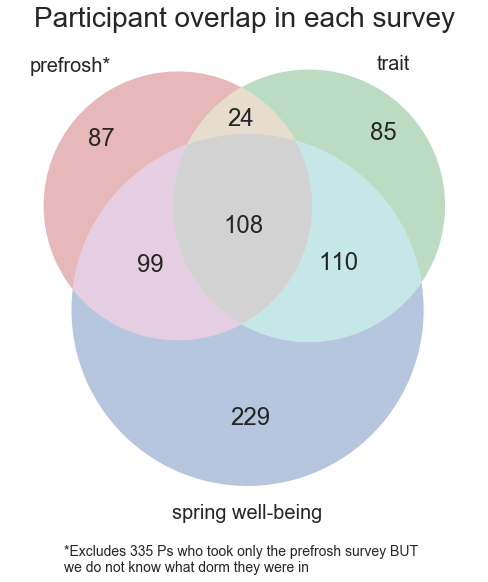

In [19]:
fig, ax = plt.subplots(1)
fig.set_size_inches(9, 9)
ax.set_title('Participant overlap in each survey', fontsize=28)
labels = ['prefrosh*', 'trait', 'spring well-being']
v = venn3(ax=ax, set_labels=labels, subsets = (
    table[1, 1, 0, 0], table[1, 0, 1, 0], table[1, 1, 1, 0],
    table[1, 0, 0, 1], table[1, 1, 0, 1], table[1, 0, 1, 1],
    table[1, 1, 1, 1]))

for lab in v.set_labels:
    lab.set_fontsize(20)
for lab in v.subset_labels:
    lab.set_fontsize(24)

ax.text(-.5, -.8,
        f'*Excludes {table[0, 1, 0, 0]} Ps who took only the prefrosh survey BUT\n'
        'we do not know what dorm they were in',
        verticalalignment='top')
fig.savefig(OUTPUT_VENN_DIAGRAM_FILENAME)